In [1]:
import math
import stackstac
import torch
import yaml
import geopandas as gpd
import numpy as np
import pandas as pd
import pystac_client
from box import Box
from matplotlib import pyplot as plt
from rasterio.enums import Resampling
from shapely import Point
from sklearn import decomposition, svm
from torchvision.transforms import v2

/Users/bmetzler/anaconda3/envs/data_processing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data download/preprocessing

In [2]:
# Point over San Pedro, Cote d'Ivoire
lat, lon = 5.562682,-6.515004

# Dates 
start = "2019-01-01"
end = "2019-05-01"

In [3]:
## accessing data from the planetary computer through pystac client
STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"  ##Sentinel-2 Level 2A data

# Search the catalogue
catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 1e-5, lat - 1e-5, lon + 1e-5, lat + 1e-5),
    max_items=100,
    query={"eo:cloud_cover": {"lt": 80}},
)

all_items = search.get_all_items()

# Reduce to one per date (there might be some duplicates
# based on the location)
items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(items)} items")

/Users/bmetzler/.local/lib/python3.11/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 15 items


In [4]:
## prep some further metadata/ CLAY model requires lat/lon info

# Extract coordinate system from first item
epsg = items[0].properties["proj:epsg"]

# Convert point of interest into the image projection
# (assumes all images are in the same projection)
poidf = gpd.GeoDataFrame(
    pd.DataFrame(),
    crs="EPSG:4326",
    geometry=[Point(lon, lat)],
).to_crs(epsg)

coords = poidf.iloc[0].geometry.coords[0]

# Create bounds in projection
size = 256
gsd = 10
bounds = (
    coords[0] - (size * gsd) // 2,
    coords[1] - (size * gsd) // 2,
    coords[0] + (size * gsd) // 2,
    coords[1] + (size * gsd) // 2,
)

In [5]:
# Retrieve the pixel values, for the bounding box in
# the target projection. In this example we use only
# the RGB and NIR bands.
stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float32",
    rescale=False,
    fill_value=0,
    assets=["blue", "green", "red", "nir"],
    resampling=Resampling.nearest,
)

print(stack)

stack = stack.compute()

<xarray.DataArray 'stackstac-cab449cd9f026062ee494e5ab302b03c' (time: 15,
                                                                band: 4,
                                                                y: 256, x: 256)> Size: 16MB
dask.array<fetch_raster_window, shape=(15, 4, 256, 256), dtype=float32, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/54)
  * time                                     (time) datetime64[ns] 120B 2019-...
    id                                       (time) <U24 1kB 'S2A_29NQG_20190...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 2kB 7.74e+05 ... 7.7...
  * y                                        (y) float64 2kB 6.167e+05 ... 6....
    s2:high_proba_clouds_percentage          (time) float64 120B 16.53 ... 28.83
    ...                                       ...
    gsd                                      int64 8B 10
    title                 

/Users/bmetzler/.local/lib/python3.11/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


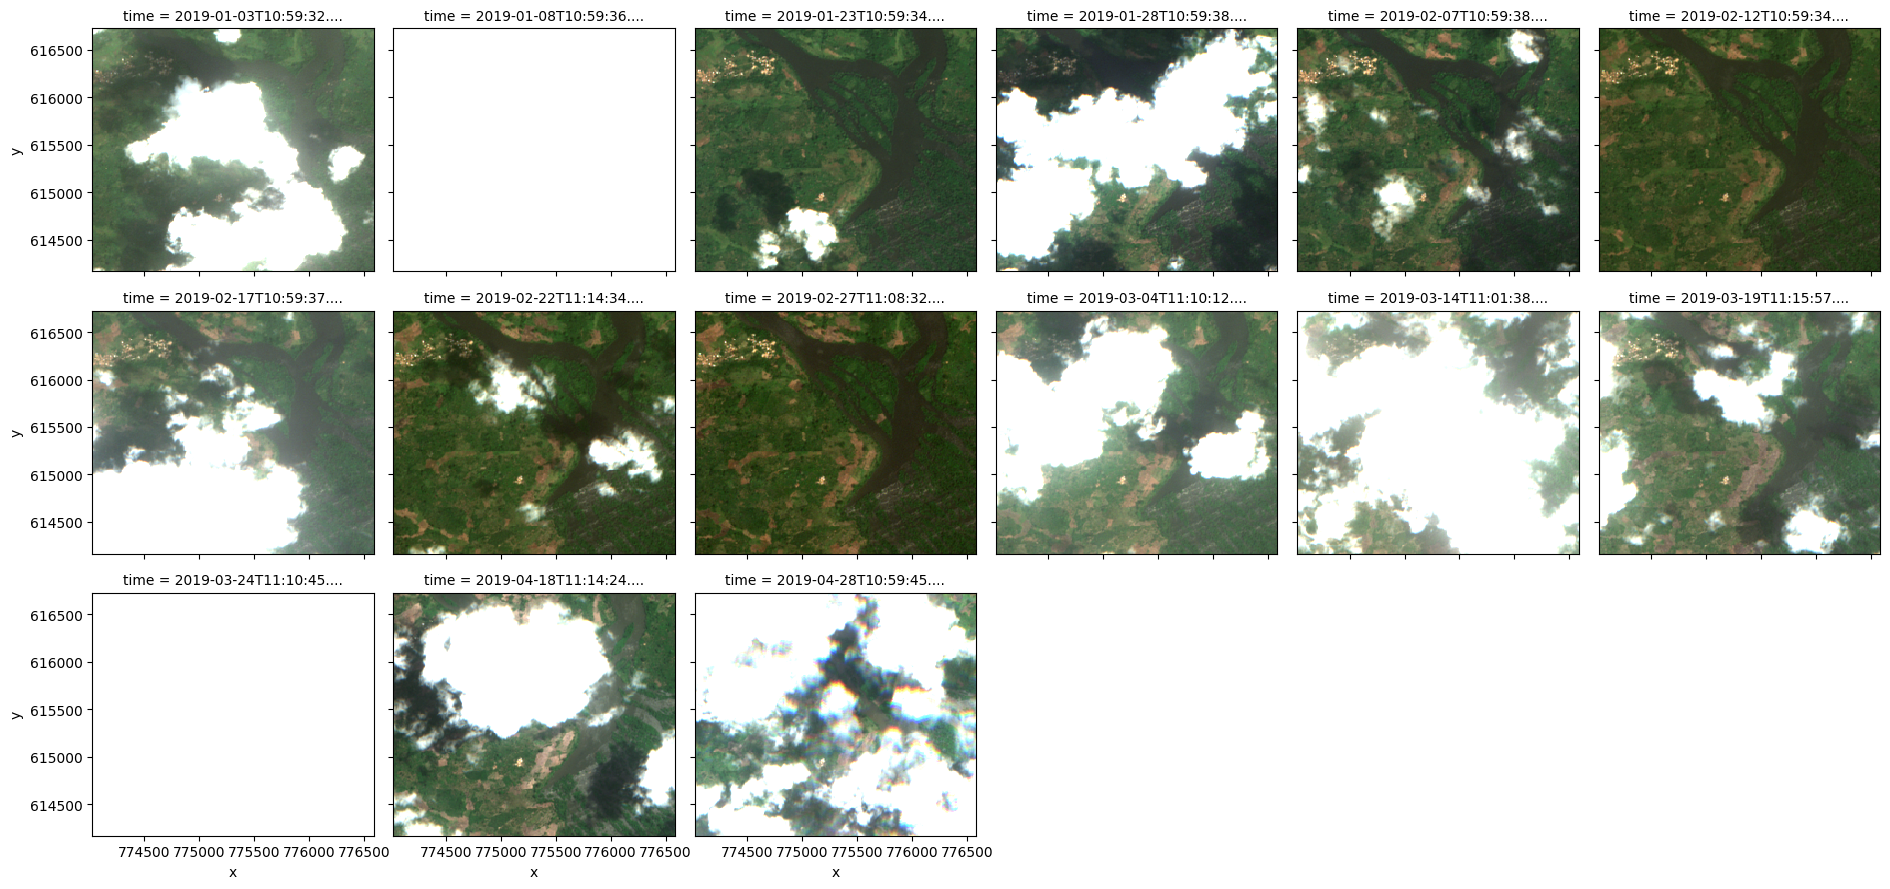

In [6]:
## view selection
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6)

## Clay model

In [137]:
from src.model import ClayMAEModule  ## git clone into here:https://github.com/Clay-foundation/model/tree/main

In [136]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "https://clay-model-ckpt.s3.amazonaws.com/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt"
torch.set_default_device(device)

In [8]:
model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path="configs/metadata.yaml", shuffle=False, mask_ratio=0
)
model.eval()

model = model.to(device)

#### metadata from https://github.com/Clay-foundation/model/blob/main/configs/metadata.yaml

/Users/bmetzler/anaconda3/envs/data_processing/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.4, which is newer than your current Lightning version: v2.1.0
/Users/bmetzler/anaconda3/envs/data_processing/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("configs/metadata.yaml"))) 
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

In [10]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

In [16]:
pixels.shape # [N, Channels, W, H]

torch.Size([15, 4, 256, 256])

In [11]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(stack.gsd.values, device=device),
    "waves": torch.tensor(waves, device=device),
}

In [12]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. 
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [13]:
embeddings.shape

(15, 768)

## Satlas Embeddigns

In [128]:
##SATLAS model

import torchvision
import collections
import satlaspretrain_models as spm
from torchvision.ops import FeaturePyramidNetwork

In [83]:
## weights downloaded from from https://github.com/allenai/satlaspretrain_models/tree/main?tab=readme-ov-file 
model_weights_path = "/Users/bmetzler/Documents/satemb_cocoa/demo_data/weights/sentinel2_swinb_mi_rgb.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.swin_transformer.swin_v2_b().to(device)
full_state_dict = torch.load(model_weights_path, map_location=device)

In [84]:
swin_prefix = 'backbone.backbone.backbone.'
fpn_prefix = 'intermediates.0.fpn.'  # FPN

In [129]:
swin_state_dict = {k[len(swin_prefix):]: v for k, v in full_state_dict.items() if k.startswith(swin_prefix)}
model.load_state_dict(swin_state_dict)

fpn_state_dict = {k[len(fpn_prefix):]: v for k, v in full_state_dict.items() if k.startswith(fpn_prefix)}
fpn = FeaturePyramidNetwork([128, 256, 512, 1024], out_channels=128).to(device) 
fpn.load_state_dict(fpn_state_dict)

<All keys matched successfully>

In [87]:
pixels.shape

torch.Size([15, 4, 256, 256])

In [135]:
## only use RGB since that's the model we loaded/// caution! Satlas model needs diff normalisation (/255) - this is just used for demo
im = pixels[:, :3, :, :]
im.shape

torch.Size([15, 3, 256, 256])

In [124]:
# Assume im is shape (N, C, H, W), with N aligned images of the same location at different times.
# First get feature maps of each individual image.
x = im
outputs = []
for layer in model.features:
    x = layer(x)
    outputs.append(x.permute(0, 3, 1, 2))
feature_maps = [outputs[-7], outputs[-5], outputs[-3], outputs[-1]]
# Now apply max temporal pooling.
feature_maps = [
    m.amax(dim=0)
    for m in feature_maps
]

torch.Size([15, 128, 64, 64])


In [118]:
for i in range(0,4):
    print(feature_maps[i].shape)

torch.Size([128, 64, 64])
torch.Size([256, 32, 32])
torch.Size([512, 16, 16])
torch.Size([1024, 8, 8])


In [131]:
# Process feature maps with FPN and extract features
inp = collections.OrderedDict([('feat{}'.format(i), el.unsqueeze(0)) for i, el in enumerate(feature_maps)]) ## add batch dimension for code to work

In [133]:
output = fpn(inp)
output = list(output.values())

avgpool = torch.nn.AdaptiveAvgPool2d(1)
embeddings_satlas = avgpool(output[-1])[:, :, 0, 0]

In [134]:
embeddings_satlas.shape

torch.Size([1, 128])